In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
from pygam import LinearGAM, s
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ================ DATA LOADING AND PREPARATION ================

def load_and_prepare_data(file_path, start_date='1959-01-01'):
    """Load and prepare the inflation data."""
    # Load data
    df = pd.read_csv(file_path, parse_dates=['observation_date'])
    df.set_index('observation_date', inplace=True)
    
    # Filter by start date
    df = df.loc[start_date:]
    
    # Calculate inflation rate
    df['Inflation_Rate'] = (df['CPIAUCSL'].pct_change(periods=12)) * 100
    
    # Drop unnecessary columns
    df.drop(columns=['CPIAUCSL'], inplace=True)
    if 'CES0500000003' in df.columns:
        df.drop(columns=['CES0500000003'], inplace=True)
    
    return df


In [3]:
# ================ EXPLORATORY DATA ANALYSIS ================

def plot_distributions(df):
    """Plot histograms and boxplots of features."""
    # Histograms
    df.hist(figsize=(12, 8), bins=30)
    plt.suptitle("Feature Distributions", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Boxplots
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df)
    plt.xticks(rotation=45)
    plt.title("Boxplot of Features")
    plt.tight_layout()
    plt.show()
    
    # Smaller features boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df[['UNRATE', 'GS10', 'FEDFUNDS', 'Inflation_Rate']])
    plt.xticks(rotation=45)
    plt.title("Boxplot of Smaller Features")
    plt.tight_layout()
    plt.show()

def plot_correlations(df):
    """Plot correlation heatmap and pairplot."""
    # Correlation heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Feature Correlations")
    plt.tight_layout()
    plt.show()
    
    # Pairplot
    sns.pairplot(df[['Inflation_Rate', 'UNRATE', 'GDP', 'FEDFUNDS']])
    plt.tight_layout()
    plt.show()

In [4]:
# ================ TIME SERIES ANALYSIS ================

def check_stationarity(series, title):
    """Test stationarity using ADF and KPSS tests."""
    print(f"\n=== Stationarity Tests for {title} ===")
    
    # ADF Test
    adf_result = adfuller(series.dropna())
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value:.4f}')
    
    if adf_result[1] < 0.05:
        print("Result: Series is STATIONARY (reject H0)")
    else:
        print("Result: Series is NON-STATIONARY (fail to reject H0)")
    
    # KPSS Test
    kpss_result = kpss(series.dropna())
    print('\nKPSS Statistic: {:.4f}'.format(kpss_result[0]))
    print('p-value: {:.4f}'.format(kpss_result[1]))
    print('Critical Values:')
    for key, value in kpss_result[3].items():
        print(f'\t{key}: {value:.4f}')
    
    if kpss_result[1] < 0.05:
        print("Result: Series is NON-STATIONARY (reject H0)")
    else:
        print("Result: Series is STATIONARY (fail to reject H0)")
    
    return adf_result[1] < 0.05  # Return True if stationary

def analyze_time_series(df):
    """Analyze time series properties of inflation rate."""
    # Test stationarity
    check_stationarity(df['Inflation_Rate'], 'Inflation_Rate')
    
    # Plot time series
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Inflation_Rate'])
    plt.title('Inflation Rate Over Time')
    plt.xlabel('Date')
    plt.ylabel('Inflation Rate (%)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Distribution plots
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df['Inflation_Rate'].dropna(), kde=True)
    plt.title('Distribution of Inflation Rate')
    
    plt.subplot(1, 2, 2)
    stats.probplot(df['Inflation_Rate'].dropna(), plot=plt)
    plt.title('Q-Q Plot of Inflation Rate')
    plt.tight_layout()
    plt.show()
    
    # ACF and PACF plots
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plot_acf(df['Inflation_Rate'].dropna(), lags=36, ax=plt.gca())
    plt.title('Autocorrelation Function')
    
    plt.subplot(1, 2, 2)
    plot_pacf(df['Inflation_Rate'].dropna(), lags=36, ax=plt.gca())
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    plt.show()
    
    # Check for seasonality
    if len(df) >= 8:
        plt.figure(figsize=(12, 6))
        df['quarter'] = df.index.quarter
        seasonal = df.groupby('quarter')['Inflation_Rate'].mean()
        seasonal.index = seasonal.index.map(lambda x: {
            1: 'Q1', 2: 'Q2', 3: 'Q3', 4: 'Q4'
        }[x])
        seasonal.plot(kind='bar', color='teal')
        plt.title('Quarterly Seasonal Pattern of Inflation Rate')
        plt.ylabel('Average Inflation Rate (%)')
        plt.xticks(rotation=0)
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()
        df.drop(columns=['quarter'], inplace=True, errors='ignore')



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1959-01-01 to 2025-01-01
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UNRATE          264 non-null    float64
 1   GDP             264 non-null    float64
 2   PCE             264 non-null    float64
 3   FEDFUNDS        264 non-null    float64
 4   GS10            264 non-null    float64
 5   M2SL            264 non-null    float64
 6   GDPC1           264 non-null    float64
 7   CIVPART         264 non-null    float64
 8   PPIACO          264 non-null    float64
 9   Inflation_Rate  253 non-null    float64
dtypes: float64(10)
memory usage: 22.8 KB
None

First few rows:
                  UNRATE      GDP    PCE  FEDFUNDS  GS10   M2SL     GDPC1  \
observation_date                                                            
1959-01-01           5.8  510.330  309.5      2.57  3.99  287.8  3352.129   
1959-04-01           5.1

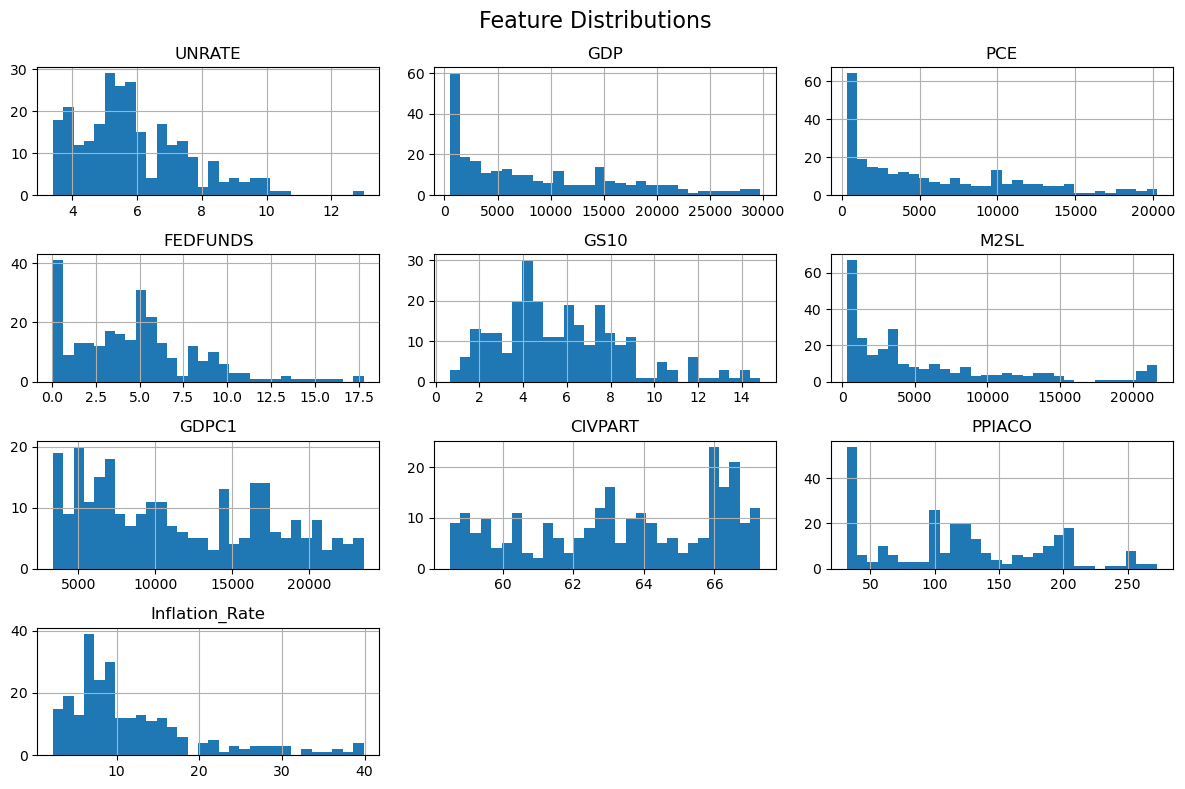

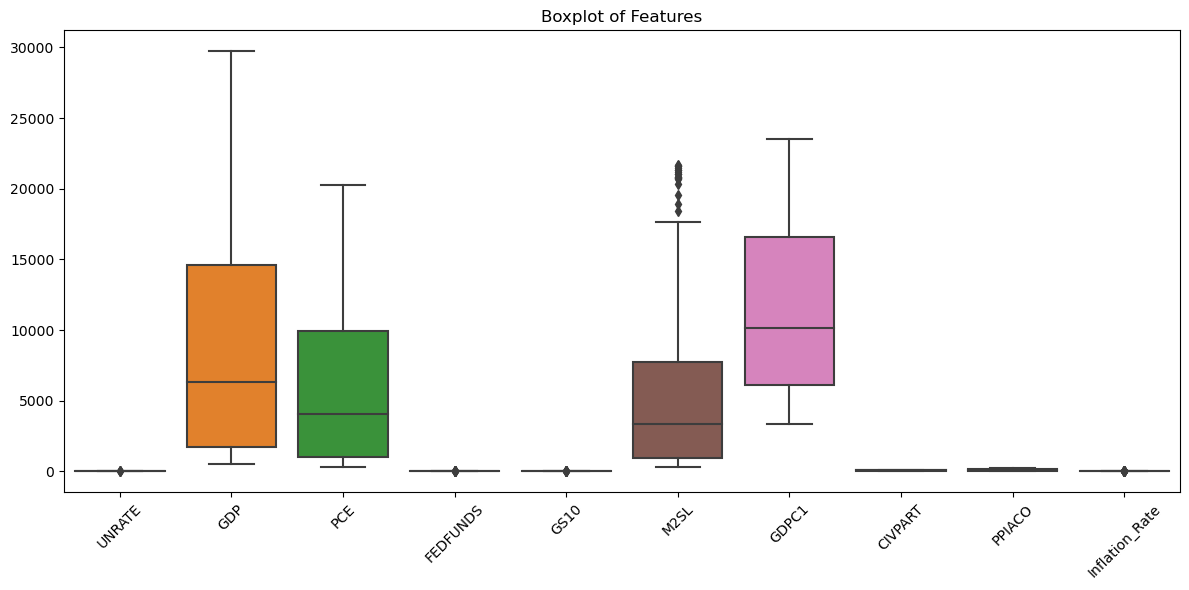

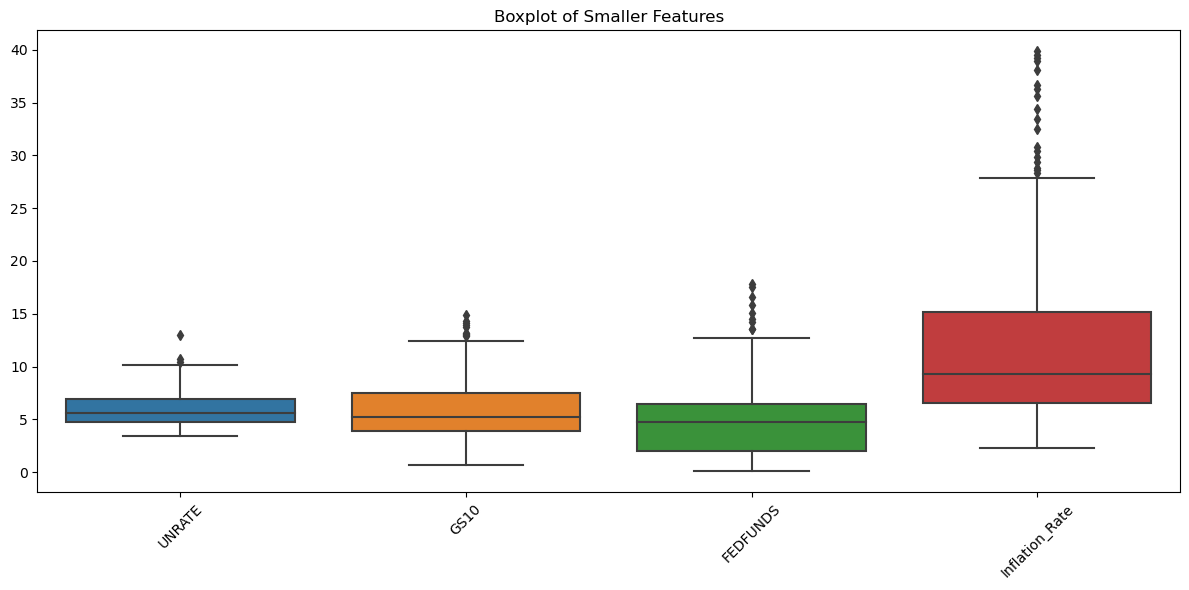


Generating correlation plots...


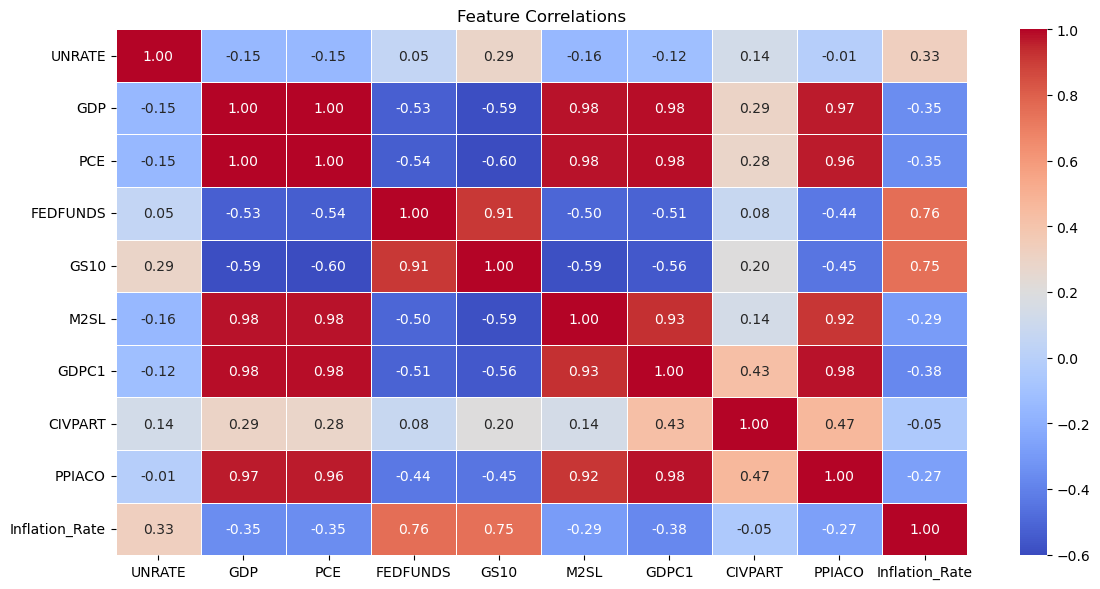

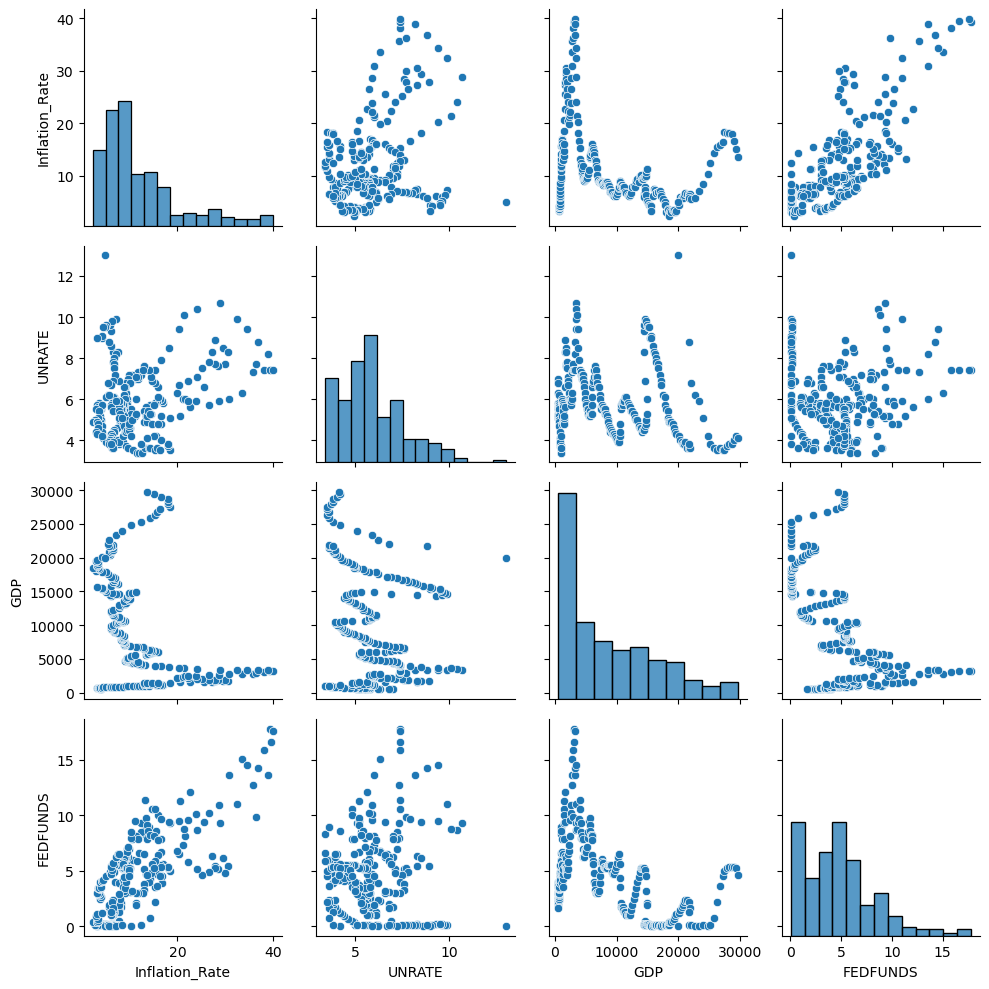


Performing time series analysis...

=== Stationarity Tests for Inflation_Rate ===
ADF Statistic: -2.1415
p-value: 0.2281
Critical Values:
	1%: -3.4581
	5%: -2.8738
	10%: -2.5733
Result: Series is NON-STATIONARY (fail to reject H0)

KPSS Statistic: 0.5952
p-value: 0.0231
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
Result: Series is NON-STATIONARY (reject H0)


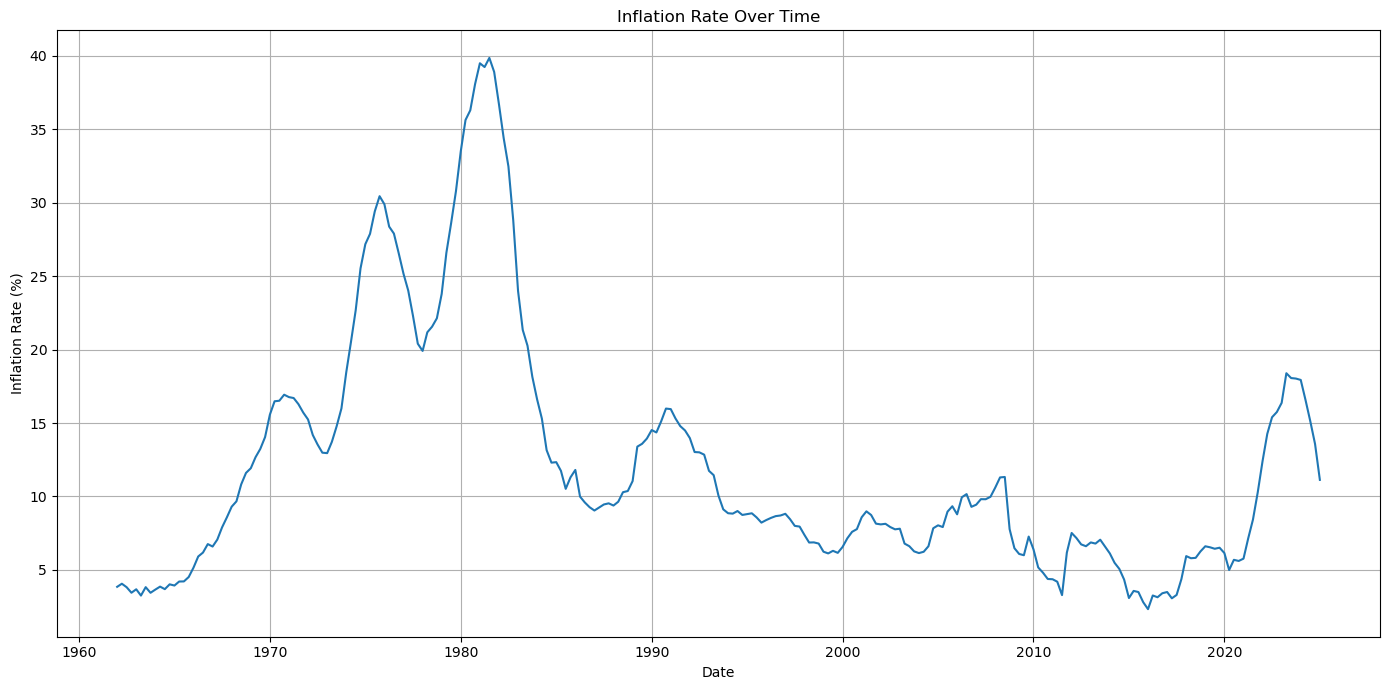

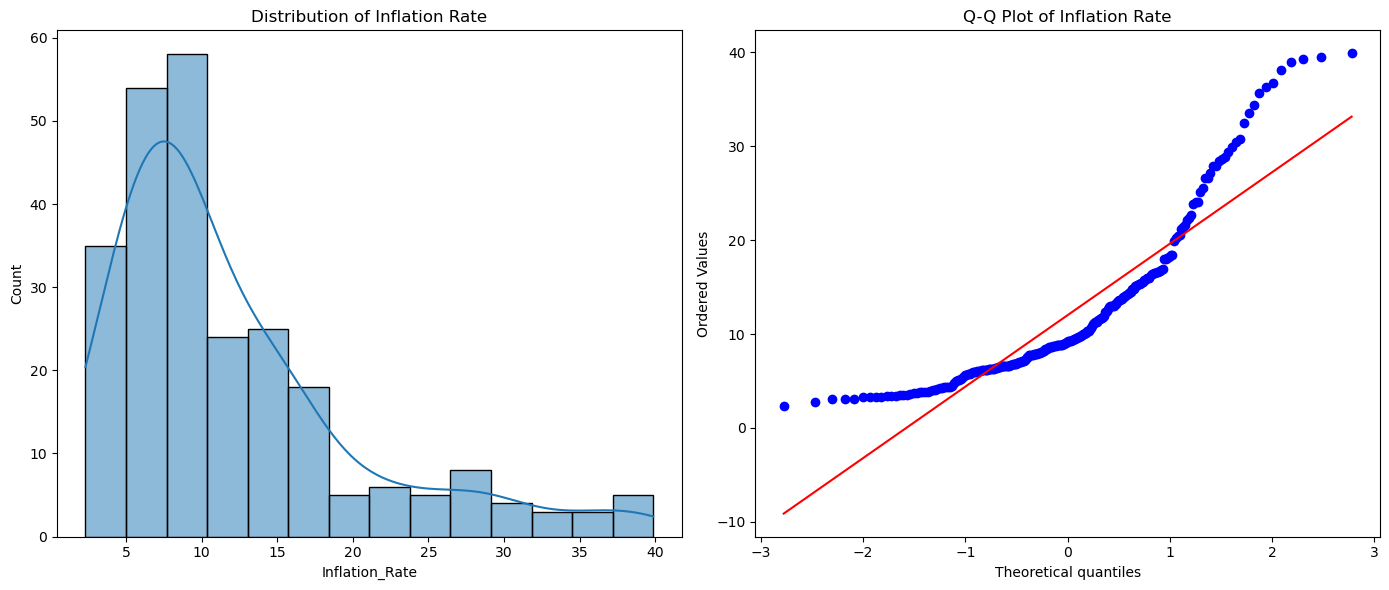

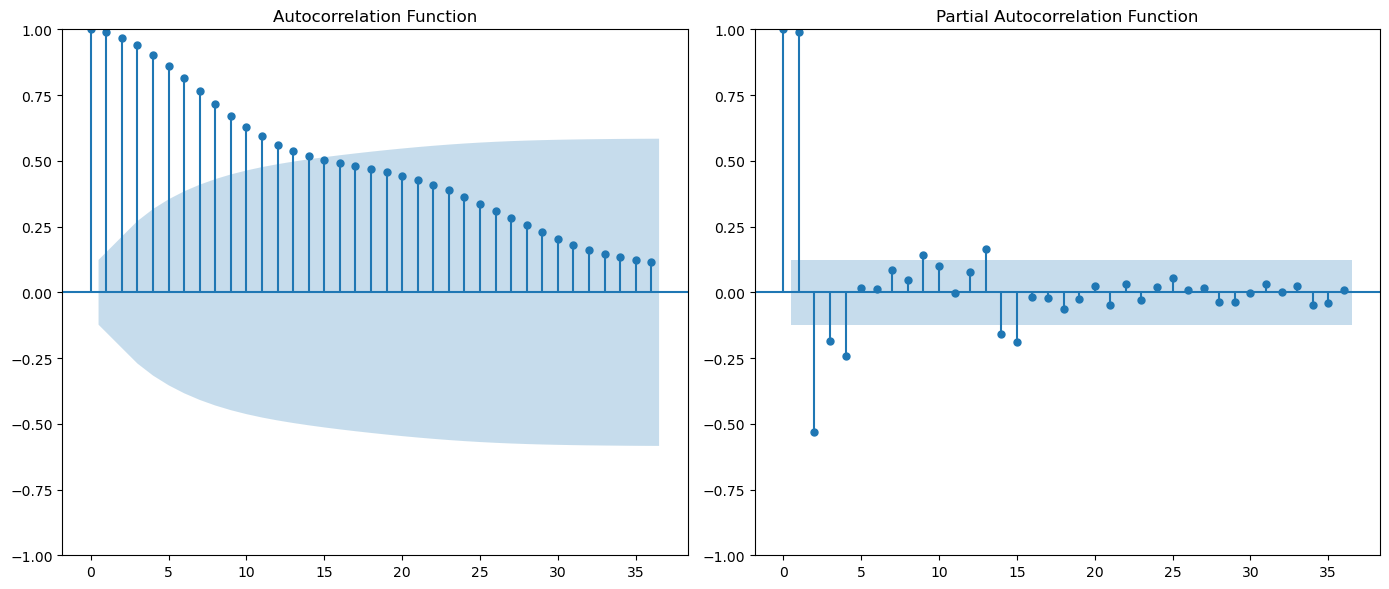

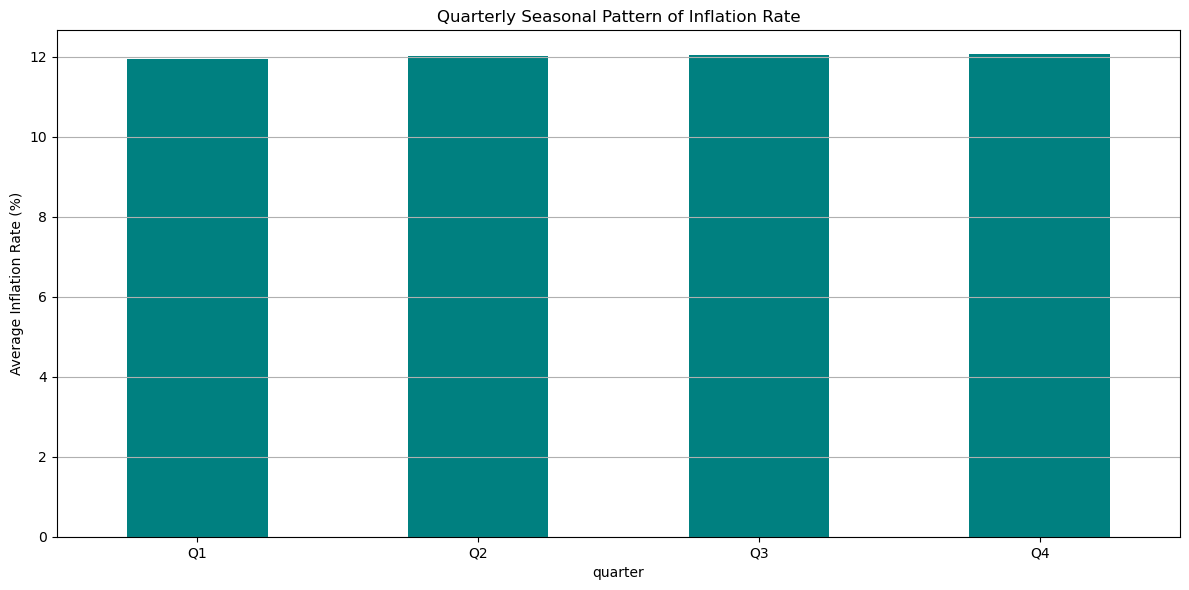

In [5]:
# First, let's load your data
df = load_and_prepare_data('./fredupdated.csv')

# Print basic information about the DataFrame
print("\nDataFrame Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

# Run the exploratory data analysis
print("\nGenerating distribution plots...")
plot_distributions(df)

print("\nGenerating correlation plots...")
plot_correlations(df)

print("\nPerforming time series analysis...")
analyze_time_series(df)


Original Data Shape: (265, 5)
After removing NaN values from differencing:
First Differencing Shape: (251, 5)
Seasonal Differencing Shape: (240, 5)
Both Differencing Shape: (239, 5)

Stationarity Tests for Transformed Inflation Rate:

1. First Differencing:

=== Stationarity Tests for First Differenced Inflation ===
ADF Statistic: -3.5388
p-value: 0.0070
Critical Values:
	1%: -3.4581
	5%: -2.8738
	10%: -2.5733
Result: Series is STATIONARY (reject H0)

KPSS Statistic: 0.0873
p-value: 0.1000
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
Result: Series is STATIONARY (fail to reject H0)

2. Seasonal Differencing:

=== Stationarity Tests for Seasonally Differenced Inflation ===
ADF Statistic: -4.0157
p-value: 0.0013
Critical Values:
	1%: -3.4598
	5%: -2.8745
	10%: -2.5737
Result: Series is STATIONARY (reject H0)

KPSS Statistic: 0.1506
p-value: 0.1000
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
Result: Series is STATIONARY (fail to reject H0)



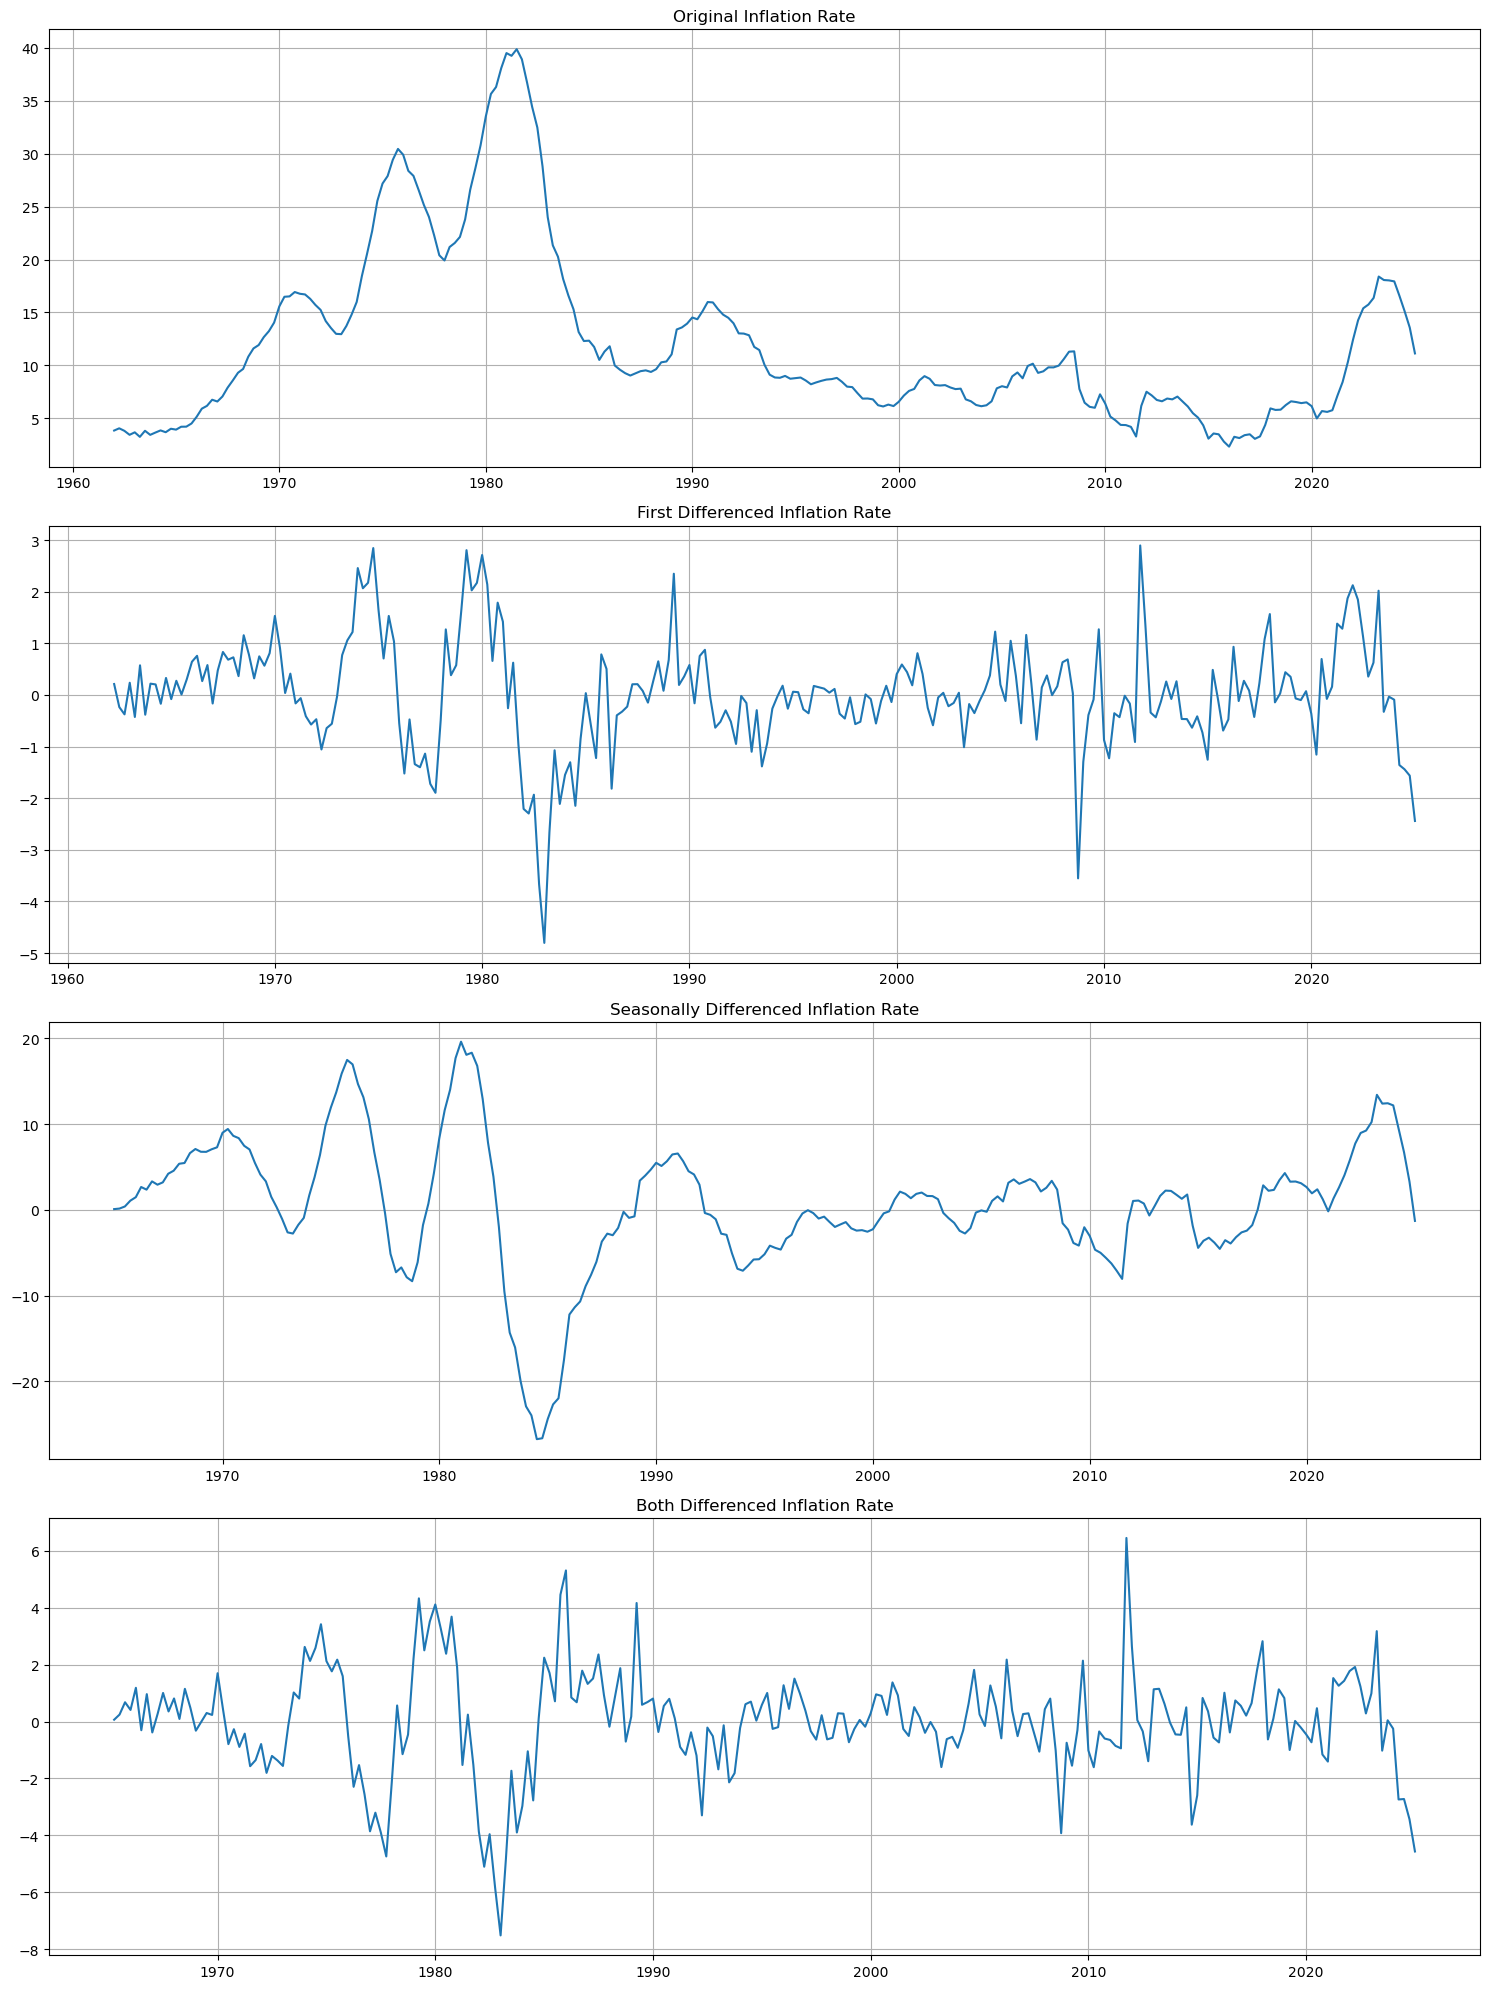


Correlations in First Differenced Data:


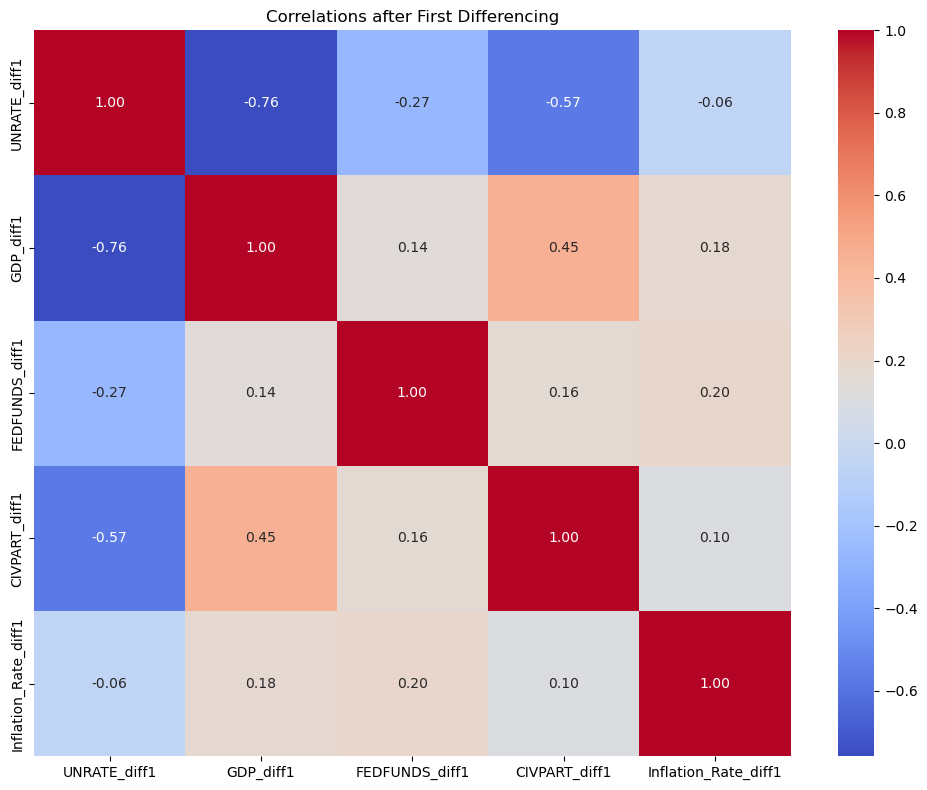

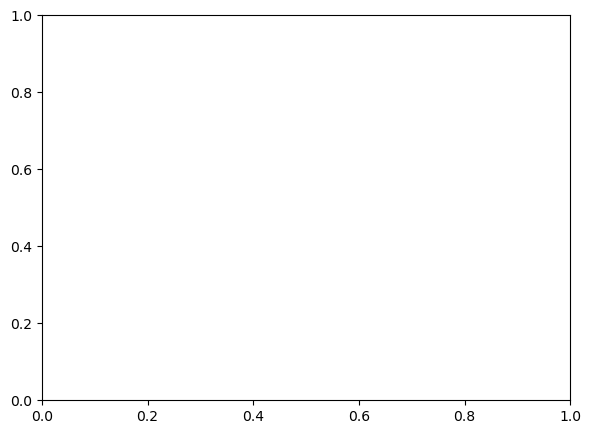

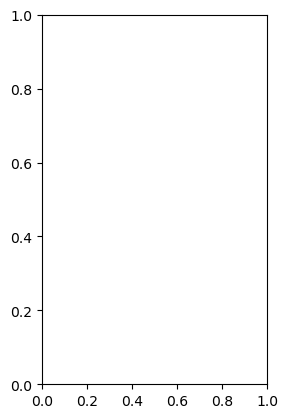

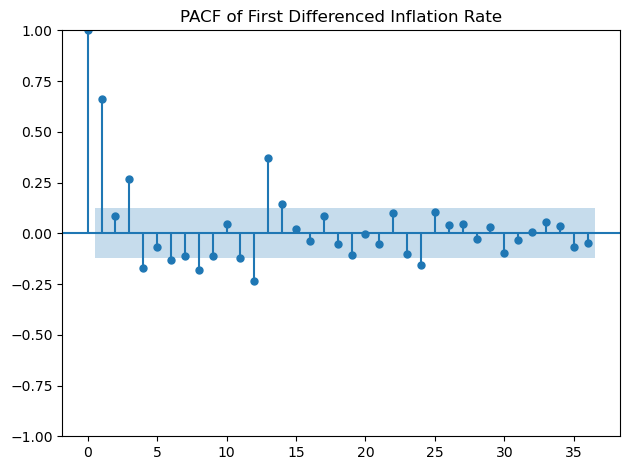

In [6]:
# Keep only the selected variables and apply differencing
def preprocess_data(df):
    """
    Remove highly correlated variables and apply differencing
    """
    # Keep only selected variables
    selected_vars = ['UNRATE', 'GDP', 'FEDFUNDS', 'CIVPART', 'Inflation_Rate']
    df_cleaned = df[selected_vars].copy()
    
    # Apply first differencing to all variables
    df_diff = pd.DataFrame()
    for column in df_cleaned.columns:
        df_diff[f'{column}_diff1'] = df_cleaned[column].diff()
    
    # Apply seasonal differencing (12 months) to handle seasonal patterns
    df_seasonal_diff = pd.DataFrame()
    for column in df_cleaned.columns:
        df_seasonal_diff[f'{column}_diff12'] = df_cleaned[column].diff(12)
    
    # Combine both types of differencing
    df_both_diff = pd.DataFrame()
    for column in df_cleaned.columns:
        # Apply seasonal differencing first, then first differencing
        seasonal = df_cleaned[column].diff(12)
        df_both_diff[f'{column}_both_diff'] = seasonal.diff()
    
    print("\nOriginal Data Shape:", df_cleaned.shape)
    print("After removing NaN values from differencing:")
    print("First Differencing Shape:", df_diff.dropna().shape)
    print("Seasonal Differencing Shape:", df_seasonal_diff.dropna().shape)
    print("Both Differencing Shape:", df_both_diff.dropna().shape)
    
    # Check stationarity of the transformed inflation rate
    print("\nStationarity Tests for Transformed Inflation Rate:")
    print("\n1. First Differencing:")
    check_stationarity(df_diff['Inflation_Rate_diff1'].dropna(), 'First Differenced Inflation')
    
    print("\n2. Seasonal Differencing:")
    check_stationarity(df_seasonal_diff['Inflation_Rate_diff12'].dropna(), 'Seasonally Differenced Inflation')
    
    print("\n3. Both Differencing:")
    check_stationarity(df_both_diff['Inflation_Rate_both_diff'].dropna(), 'Both Differenced Inflation')
    
    # Plot the transformed series
    fig, axes = plt.subplots(4, 1, figsize=(15, 20))
    
    # Original
    axes[0].plot(df_cleaned['Inflation_Rate'])
    axes[0].set_title('Original Inflation Rate')
    axes[0].grid(True)
    
    # First differencing
    axes[1].plot(df_diff['Inflation_Rate_diff1'])
    axes[1].set_title('First Differenced Inflation Rate')
    axes[1].grid(True)
    
    # Seasonal differencing
    axes[2].plot(df_seasonal_diff['Inflation_Rate_diff12'])
    axes[2].set_title('Seasonally Differenced Inflation Rate')
    axes[2].grid(True)
    
    # Both differencing
    axes[3].plot(df_both_diff['Inflation_Rate_both_diff'])
    axes[3].set_title('Both Differenced Inflation Rate')
    axes[3].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Return all versions for further analysis
    return {
        'original': df_cleaned,
        'first_diff': df_diff,
        'seasonal_diff': df_seasonal_diff,
        'both_diff': df_both_diff
    }

# Apply the preprocessing
transformed_data = preprocess_data(df)

# Check correlations in transformed data
print("\nCorrelations in First Differenced Data:")
plt.figure(figsize=(10, 8))
sns.heatmap(transformed_data['first_diff'].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlations after First Differencing')
plt.tight_layout()
plt.show()

# Plot ACF and PACF of the transformed inflation rate
plt.figure(figsize=(15, 5))
plt.subplot(121)
plot_acf(transformed_data['first_diff']['Inflation_Rate_diff1'].dropna(), lags=36)
plt.title('ACF of First Differenced Inflation Rate')

plt.subplot(122)
plot_pacf(transformed_data['first_diff']['Inflation_Rate_diff1'].dropna(), lags=36)
plt.title('PACF of First Differenced Inflation Rate')
plt.tight_layout()
plt.show()

In [7]:
# 1. Prepare the final dataset using seasonal differencing
def prepare_final_dataset(transformed_data):
    # Use the seasonal differenced data
    df_final = transformed_data['seasonal_diff'].copy()
    
    # Create lag features (based on PACF)
    for col in df_final.columns:
        # Create lags 1, 2, and 4 (quarterly)
        for lag in [1, 2, 4]:
            df_final[f'{col}_lag{lag}'] = df_final[col].shift(lag)
    
    # Add quarterly dummies
    df_final['quarter'] = df_final.index.quarter
    df_final = pd.get_dummies(df_final, columns=['quarter'], prefix='Q')
    
    # Drop NaN values
    df_final = df_final.dropna()
    
    return df_final

# 2. Split the data into training and testing sets
def split_data(df_final, test_size=24):  # 2 years of quarterly data
    """Split the data into training and testing sets"""
    train = df_final.iloc[:-test_size]
    test = df_final.iloc[-test_size:]
    
    # Separate features and target
    target_col = 'Inflation_Rate_diff12'
    features = [col for col in df_final.columns if col != target_col]
    
    X_train = train[features]
    y_train = train[target_col]
    X_test = test[features]
    y_test = test[target_col]
    
    return X_train, X_test, y_train, y_test

# 3. Implement the preprocessing and splitting
df_final = prepare_final_dataset(transformed_data)

# Print feature information
print("Final dataset shape:", df_final.shape)
print("\nFeatures included:")
print(df_final.columns.tolist())

X_train, X_test, y_train, y_test = split_data(df_final)

print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# 4. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame to maintain column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

Final dataset shape: (236, 24)

Features included:
['UNRATE_diff12', 'GDP_diff12', 'FEDFUNDS_diff12', 'CIVPART_diff12', 'Inflation_Rate_diff12', 'UNRATE_diff12_lag1', 'UNRATE_diff12_lag2', 'UNRATE_diff12_lag4', 'GDP_diff12_lag1', 'GDP_diff12_lag2', 'GDP_diff12_lag4', 'FEDFUNDS_diff12_lag1', 'FEDFUNDS_diff12_lag2', 'FEDFUNDS_diff12_lag4', 'CIVPART_diff12_lag1', 'CIVPART_diff12_lag2', 'CIVPART_diff12_lag4', 'Inflation_Rate_diff12_lag1', 'Inflation_Rate_diff12_lag2', 'Inflation_Rate_diff12_lag4', 'Q_1', 'Q_2', 'Q_3', 'Q_4']

Training set shape: (212, 23)
Testing set shape: (24, 23)



Model Comparison:
           Model      RMSE       MAE        R2
1          Lasso  1.679202  1.367118  0.830446
2  Random Forest  2.478495  1.981447  0.630616
0          Ridge  3.463223  2.563201  0.278787
4         SARIMA  3.890410  3.201855  0.089892
3            GAM  5.319484  4.053491 -0.701537


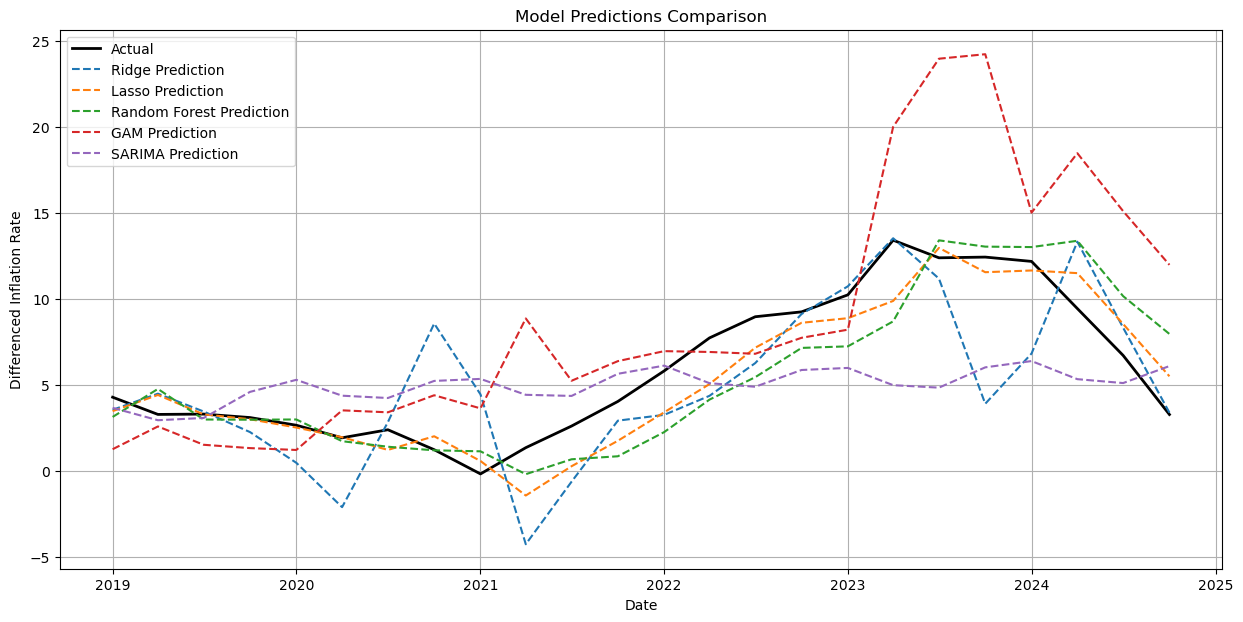

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (10,) and arg 3 with shape (23,).

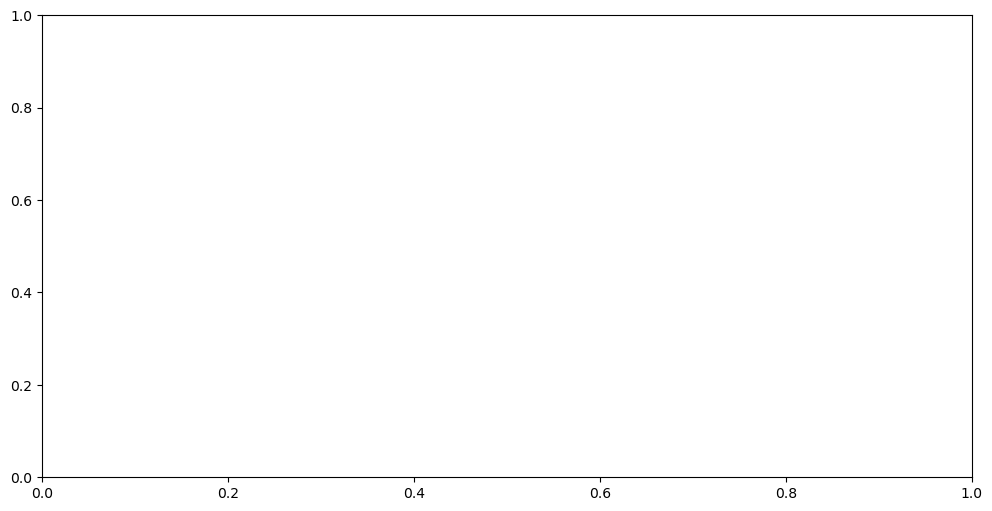

In [8]:
def implement_models(X_train_scaled, X_test_scaled, y_train, y_test):
    """Implement and evaluate multiple models"""
    models = {}
    predictions = {}
    results = []
    
    # 1. Ridge Regression
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train_scaled, y_train)
    y_pred_ridge = ridge.predict(X_test_scaled)
    predictions['Ridge'] = y_pred_ridge
    
    # Feature importance for Ridge
    ridge_importance = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'Importance': np.abs(ridge.coef_)
    }).sort_values('Importance', ascending=False)
    
    # 2. Lasso Regression
    lasso = Lasso(alpha=0.1)
    lasso.fit(X_train_scaled, y_train)
    y_pred_lasso = lasso.predict(X_test_scaled)
    predictions['Lasso'] = y_pred_lasso
    
    # Feature importance for Lasso
    lasso_importance = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'Importance': np.abs(lasso.coef_)
    }).sort_values('Importance', ascending=False)
    
    # 3. Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)
    y_pred_rf = rf.predict(X_test_scaled)
    predictions['Random Forest'] = y_pred_rf
    
    # Feature importance for Random Forest
    rf_importance = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # 4. GAM
    gam = LinearGAM()
    gam.fit(X_train_scaled, y_train)
    y_pred_gam = gam.predict(X_test_scaled)
    predictions['GAM'] = y_pred_gam
    
    # 5. SARIMA
    # Since SARIMA works with the original series, we'll use it separately
    sarima_model = SARIMAX(y_train, 
                          order=(1, 0, 1),
                          seasonal_order=(1, 1, 1, 4),
                          enforce_stationarity=False)
    sarima_results = sarima_model.fit(disp=False)
    y_pred_sarima = sarima_results.forecast(steps=len(y_test))
    predictions['SARIMA'] = y_pred_sarima
    
    # Evaluate all models
    for name, y_pred in predictions.items():
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            'Model': name,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return predictions, results_df, {
        'Ridge': ridge_importance,
        'Lasso': lasso_importance,
        'Random Forest': rf_importance
    }

# Implement models and get results
predictions, results_df, feature_importance = implement_models(X_train_scaled, X_test_scaled, y_train, y_test)

# Print model comparison
print("\nModel Comparison:")
print(results_df.sort_values('RMSE'))

# Plot predictions
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, 'k-', label='Actual', linewidth=2)

for model_name, y_pred in predictions.items():
    plt.plot(y_test.index, y_pred, '--', label=f'{model_name} Prediction')

plt.title('Model Predictions Comparison')
plt.xlabel('Date')
plt.ylabel('Differenced Inflation Rate')
plt.legend()
plt.grid(True)
plt.show()

# Plot feature importance for the best performing model
best_model = results_df.iloc[results_df['RMSE'].idxmin()]['Model']
plt.figure(figsize=(12, 6))
importance_df = feature_importance.get(best_model)
if importance_df is not None:
    plt.barh(range(len(importance_df)), importance_df['Importance'][:10])
    plt.yticks(range(len(importance_df)), importance_df['Feature'][:10])
    plt.title(f'Top 10 Feature Importance - {best_model}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

# Residual analysis for the best model
best_predictions = predictions[best_model]
residuals = y_test - best_predictions

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.scatter(best_predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.subplot(122)
plt.hist(residuals, bins=20)
plt.title('Residual Distribution')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Calculate inverse transformed predictions for interpretability
def inverse_seasonal_difference(original_series, differenced_series, periods=12):
    """Inverse transform seasonal differencing"""
    result = differenced_series.copy()
    for i in range(len(result)):
        if i < periods:
            result.iloc[i] += original_series.iloc[i]
        else:
            result.iloc[i] += result.iloc[i-periods]
    return result

# Get original series values
original_inflation = df['Inflation_Rate']

# Inverse transform predictions for the best model
y_test_inv = inverse_seasonal_difference(original_inflation, y_test)
pred_inv = inverse_seasonal_difference(original_inflation, pd.Series(best_predictions, index=y_test.index))

# Plot the final results in original scale
plt.figure(figsize=(15, 7))
plt.plot(original_inflation.index[-36:], original_inflation.iloc[-36:], 'k-', label='Actual', linewidth=2)
plt.plot(y_test_inv.index, y_test_inv, 'b-', label='Test Data (Original Scale)')
plt.plot(pred_inv.index, pred_inv, 'r--', label=f'{best_model} Predictions')
plt.title('Inflation Rate Predictions - Original Scale')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()